In [11]:
%matplotlib inline

In [37]:
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
from scipy import stats
from statsmodels.stats.proportion import proportions_ztest

In [ ]:
def generar_dataset_csv(salida_path: Path):
    rng = np.random.default_rng(42)  # Generador aleatorio reproducible
    n = 200  # Cantidad de registros

    # Proveedor
    proveedor = rng.choice(['A', 'B'], size=n, p=[0.55, 0.45])

    # Medias y desviaciones estándar para el espesor según proveedor
    media_A, media_B = 0.90, 0.88
    desv_A, desv_B = 0.06, 0.07

    # Espesor de perfiles (mm)
    espesor = np.where(
        proveedor == 'A',
        rng.normal(media_A, desv_A, size=n),
        rng.normal(media_B, desv_B, size=n)
    )
    espesor = np.clip(espesor, 0.70, 1.10)  # limitar valores

    # Resistencia a la fluencia (MPa)
    resistencia_fluencia = 230 + 80*(espesor - 0.85) + rng.normal(0, 12, size=n)

    # Recubrimiento de zinc (g/m²)
    recubrimiento = np.where(
        proveedor == 'A',
        rng.normal(220, 18, size=n),
        rng.normal(210, 20, size=n)
    )
    recubrimiento = np.clip(recubrimiento, 160, 280)

    # Valor U base y penalización por puente térmico
    U_base = 0.35 - 0.06*(espesor - 0.85) + rng.normal(0, 0.015, size=n)
    penalizacion_puente = np.where(proveedor == 'A', 0.012, 0.015)
    valor_U = np.clip(U_base + penalizacion_puente, 0.18, 0.55)

    # Cumple requisito de U
    cumple_U = (valor_U <= 0.40)

    # Lotes y códigos de panel
    lote = rng.integers(1001, 1012, size=n)
    id_panel = [f"P{b}-{i:03d}" for b, i in zip(lote, rng.integers(1, 160, size=n))]

    # Crear DataFrame
    df = pd.DataFrame({
        "id_panel": id_panel,
        "proveedor": proveedor,
        "lote": lote,
        "espesor_mm": np.round(espesor, 3),
        "resistencia_fluencia_MPa": np.round(resistencia_fluencia, 1),
        "recubrimiento_zinc_g_m2": np.round(recubrimiento, 0),
        "U_W_m2K": np.round(valor_U, 3),
        "cumple_requisito_U": cumple_U
    })

    # Guardar CSV
    df.to_csv(salida_path, index=False)
    return df

if __name__ == "__main__":
    # Directorio del script y ruta del CSV en el mismo directorio
    csv_path = Path("steelframe_inferencia_dataset.csv")  # guarda en la carpeta actual del notebook

    df = generar_dataset_csv(csv_path)
    print(f"CSV generado con {len(df)} registros en: {csv_path}")

CSV generado con 200 registros en: steelframe_inferencia_dataset.csv


In [19]:
# Cargar el CSV previamente generado
df = pd.read_csv("steelframe_inferencia_dataset.csv")

# Revisar primeras filas
print(df.head())

# Estadísticas
x = df["espesor_mm"].dropna().iloc[:200]
n = x.size
x_mean = x.mean()
x_median = x.median()
x_std = x.std(ddof=1)

print("Estadísticos descriptivos del espesor de perfiles")
print(f"Tamaño muestral (n): {n}")
print(f"Media muestral (x̄): {x_mean:.3f} mm")
print(f"Mediana: {x_median:.3f} mm")
print(f"Desvío estándar muestral (s): {x_std:.3f} mm")

    id_panel proveedor  lote  espesor_mm  resistencia_fluencia_MPa  \
0  P1010-039         B  1010       0.933                     230.4   
1  P1003-125         A  1003       0.876                     241.9   
2  P1005-093         B  1005       0.917                     238.3   
3  P1006-119         B  1006       0.831                     207.2   
4  P1008-018         A  1008       0.920                     241.8   

   recubrimiento_zinc_g_m2  U_W_m2K  cumple_requisito_U  
0                    225.0    0.342                True  
1                    239.0    0.347                True  
2                    213.0    0.383                True  
3                    226.0    0.350                True  
4                    205.0    0.338                True  
Estadísticos descriptivos del espesor de perfiles
Tamaño muestral (n): 200
Media muestral (x̄): 0.885 mm
Mediana: 0.890 mm
Desvío estándar muestral (s): 0.064 mm


Distribución de frecuencias graficada en histograma.



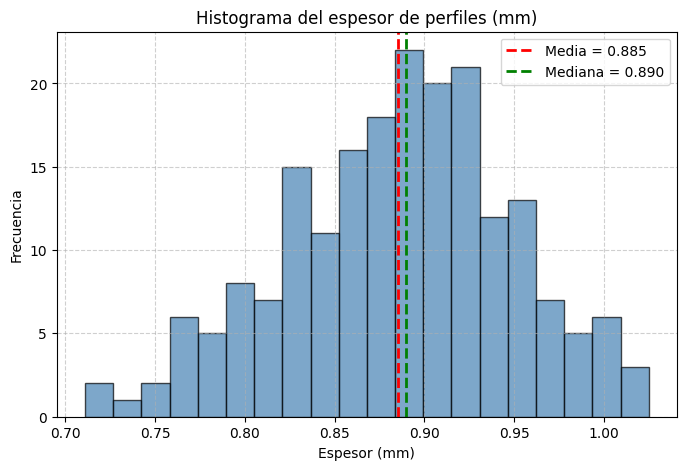

In [20]:
print("Distribución de frecuencias graficada en histograma.\n")

# === Histograma ===
plt.figure(figsize=(8,5))
plt.hist(x, bins=20, color="steelblue", edgecolor="black", alpha=0.7)
plt.axvline(x_mean, color="red", linestyle="--", linewidth=2, label=f"Media = {x_mean:.3f}")
plt.axvline(x_median, color="green", linestyle="--", linewidth=2, label=f"Mediana = {x_median:.3f}")
plt.title("Histograma del espesor de perfiles (mm)")
plt.xlabel("Espesor (mm)")
plt.ylabel("Frecuencia")
plt.legend()
plt.grid(True, linestyle="--", alpha=0.6)
plt.show()


Los proveedores producen espesores bastante variados en cuanrto al espesor esperado, lo podemos verificar al ver que la concentracion mayoritaria de los elementos no reside en el centro sino en los extremos del gráfico. 

In [33]:
# Variable de interés: espesor
y = df["resistencia_fluencia_MPa"].dropna()
n = y.size
y_mean = y.mean()
y_std = y.std(ddof=1)


print("Análisis del resistencia de los perfiles (MPa)")
print(f"Cantidad de paneles analizados: {n}")
print(f"Media muestral (ȳ): {y_mean:.3f} MPa")
print(f"Desvío estándar muestral (s): {y_std:.3f} MPa")

Análisis del resistencia de los perfiles (MPa)
Cantidad de paneles analizados: 200
Media muestral (ȳ): 232.123 MPa
Desvío estándar muestral (s): 13.398 MPa


In [31]:
# Hipótesis
mu0 = 240  # valor de referencia

# Test t unilateral (H1: μ > μ0)
t_stat, p_one_sided = stats.ttest_1samp(y, popmean=mu0, alternative="less")

print("Test t de una muestra (H1: μ < μ0)")
print(f"Cantidad de observaciones (n): {n}")
print(f"Media muestral (ȳ): {y_mean:.3f} MPa")
print(f"Desvío estándar muestral (s): {y_std:.3f} MPa")
print(f"Hipótesis nula (H0): μ ≥ {mu0} MPa")
print(f"Hipótesis alternativa (H1): μ < {mu0} MPa")
print(f"Estadístico t calculado: {t_stat:.3f}")
print(f"p-valor (unilateral): {p_one_sided:.5f}")


# Decisión
alpha = 0.05
if p_one_sided < alpha:
    print(f">>> Se RECHAZA H0 al nivel α={alpha}.")
    print("   Evidencia estadística suficiente de que μ < 240 MPa.")
else:
    print(f">>> No se puede rechazar H0 al nivel α={alpha}.")
    print("   No hay evidencia estadística suficiente de que μ < 240 MPa.")


Test t de una muestra (H1: μ < μ0)
Cantidad de observaciones (n): 200
Media muestral (ȳ): 232.123 MPa
Desvío estándar muestral (s): 13.398 MPa
Hipótesis nula (H0): μ ≥ 240 MPa
Hipótesis alternativa (H1): μ < 240 MPa
Estadístico t calculado: -8.315
p-valor (unilateral): 0.00000
>>> Se RECHAZA H0 al nivel α=0.05.
   Evidencia estadística suficiente de que μ < 240 MPa.


La resistencia del material provisto no cumple con el valor esperado de 240 MPa. La media muestral es significativamente inferior, y la prueba estadística respalda esta diferencia. Por lo tanto, no se considera adecuada para los estándares requeridos.

In [32]:
# Comparación de espesor entre proveedores
espesor_A = df.loc[df["proveedor"]=="A", "espesor_mm"]
espesor_B = df.loc[df["proveedor"]=="B", "espesor_mm"]

# Test t de Student con varianzas desiguales (Welch)
resultado_t = stats.ttest_ind(espesor_A, espesor_B, equal_var=False, alternative="greater")


print("Test t para muestras independientes (Welch)")
print(f"Cantidad de paneles proveedor A: {len(espesor_A)}")
print(f"Cantidad de paneles proveedor B: {len(espesor_B)}")
print(f"Media A (x̄A): {espesor_A.mean():.3f} mm")
print(f"Media B (x̄B): {espesor_B.mean():.3f} mm")
print(f"Desvío estándar A (sA): {espesor_A.std(ddof=1):.3f} mm")
print(f"Desvío estándar B (sB): {espesor_B.std(ddof=1):.3f} mm")
print("\nHipótesis:")
print("  H0: μA = μB")
print("  H1: μA > μB")
print(f"\nEstadístico t calculado: {resultado_t.statistic:.3f}")
print(f"p-valor (unilateral): {resultado_t.pvalue:.5f}")

alpha = 0.05
if resultado_t.pvalue < alpha:
    print(f">>> Se RECHAZA H0 al nivel α={alpha}.")
    print("   Evidencia estadística suficiente de que el espesor promedio del proveedor A es mayor que el de B.")
else:
    print(f">>> No se puede rechazar H0 al nivel α={alpha}.")
    print("   No hay evidencia estadística suficiente para afirmar que el proveedor A tiene mayor espesor promedio que B.")

Test t para muestras independientes (Welch)
Cantidad de paneles proveedor A: 108
Cantidad de paneles proveedor B: 92
Media A (x̄A): 0.890 mm
Media B (x̄B): 0.880 mm
Desvío estándar A (sA): 0.060 mm
Desvío estándar B (sB): 0.067 mm

Hipótesis:
  H0: μA = μB
  H1: μA > μB

Estadístico t calculado: 1.094
p-valor (unilateral): 0.13771
>>> No se puede rechazar H0 al nivel α=0.05.
   No hay evidencia estadística suficiente para afirmar que el proveedor A tiene mayor espesor promedio que B.


Se aplica una prueba t de Student para muestras independientes.
Dado que los desvíos estándar son ligeramente diferentes, se utilizó la versión de Welch (que no asume igualdad de varianzas).
Dado que el p-valor = 0.13771 > 0.05, no se rechaza la hipótesis nula al nivel de significancia 𝛼=0.05

In [35]:
# Separar por proveedor
for proveedor in ["A", "B"]:
    print(f"\n=== Análisis del valor U para Proveedor {proveedor} ===")
    
    U_prov = df.loc[df["proveedor"] == proveedor, "U_W_m2K"].dropna()
    n_U = U_prov.size
    media_U = U_prov.mean()
    desv_U = U_prov.std(ddof=1)
    
    # Intervalo de confianza 95%
    t_critico_U = stats.t.ppf(0.975, df=n_U-1)
    ic_U = (
        media_U - t_critico_U * desv_U / np.sqrt(n_U),
        media_U + t_critico_U * desv_U / np.sqrt(n_U)
    )
    
    # Test t unilateral: H0: μ = 0.40 vs H1: μ < 0.40
    estad_t_U, p_valor_izquierda = stats.ttest_1samp(U_prov, popmean=0.40, alternative="less")
    
    # Resultados
    print(f"Cantidad de paneles: {n_U}")
    print(f"Media muestral: {media_U:.3f} W/m²K")
    print(f"Desvío estándar: {desv_U:.3f} W/m²K")
    print(f"Intervalo de confianza 95%: ({ic_U[0]:.3f}, {ic_U[1]:.3f}) W/m²K")
    print(f"Estadístico t: {estad_t_U:.3f}")
    print(f"p-valor (una cola, H1: μ < 0.40): {p_valor_izquierda:.5f}")
    
    # Interpretación
    alpha = 0.05
    if p_valor_izquierda < alpha:
        print(f"Conclusión: Se rechaza H0 → la media de U del proveedor {proveedor} es significativamente menor a 0.40 W/m²K.")
    else:
        print(f"Conclusión: No se puede rechazar H0 → no hay evidencia suficiente de que la media de U del proveedor {proveedor} sea menor a 0.40.")



=== Análisis del valor U para Proveedor A ===
Cantidad de paneles: 108
Media muestral: 0.359 W/m²K
Desvío estándar: 0.016 W/m²K
Intervalo de confianza 95%: (0.356, 0.362) W/m²K
Estadístico t: -26.211
p-valor (una cola, H1: μ < 0.40): 0.00000
Conclusión: Se rechaza H0 → la media de U del proveedor A es significativamente menor a 0.40 W/m²K.

=== Análisis del valor U para Proveedor B ===
Cantidad de paneles: 92
Media muestral: 0.362 W/m²K
Desvío estándar: 0.018 W/m²K
Intervalo de confianza 95%: (0.359, 0.366) W/m²K
Estadístico t: -20.410
p-valor (una cola, H1: μ < 0.40): 0.00000
Conclusión: Se rechaza H0 → la media de U del proveedor B es significativamente menor a 0.40 W/m²K.


Ambos proveedores dan un U≤0.40. 

In [38]:
# Contar éxitos y tamaños por proveedor
cumple_A = df.loc[df["proveedor"] == "A", "cumple_requisito_U"]
cumple_B = df.loc[df["proveedor"] == "B", "cumple_requisito_U"]

# Éxitos: cantidad de True
x1 = cumple_A.sum()
x2 = cumple_B.sum()

# Tamaños muestrales
n1 = cumple_A.count()
n2 = cumple_B.count()

# Prueba z para diferencia de proporciones (dos colas)
stat_z, p_valor = proportions_ztest([x1, x2], [n1, n2], alternative="two-sided")

# Resultados
print("=== Prueba de diferencia de proporciones ===")
print(f"Proveedor A: {x1}/{n1} paneles cumplen → proporción = {x1/n1:.3f}")
print(f"Proveedor B: {x2}/{n2} paneles cumplen → proporción = {x2/n2:.3f}")
print(f"Estadístico z: {stat_z:.3f}")
print(f"p-valor (dos colas): {p_valor:.5f}")

alpha = 0.05
if p_valor < alpha:
    print(f">>> Se RECHAZA H0 al nivel α = {alpha}")
    print("   Hay evidencia estadística de que las proporciones de cumplimiento difieren entre A y B.")
else:
    print(f">>> No se puede rechazar H0 al nivel α = {alpha}")
    print("   No hay evidencia estadística suficiente para afirmar que las proporciones sean distintas.")


=== Prueba de diferencia de proporciones ===
Proveedor A: 107/108 paneles cumplen → proporción = 0.991
Proveedor B: 90/92 paneles cumplen → proporción = 0.978
Estadístico z: 0.724
p-valor (dos colas): 0.46927
>>> No se puede rechazar H0 al nivel α = 0.05
   No hay evidencia estadística suficiente para afirmar que las proporciones sean distintas.
